In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import bisect

In [68]:
# Warm up: European put option

r, T, K, S0 = 0.05, 0.2, 120, 100
# Define option price
def I(sigma):
    wstar = (np.log(K/S0) - (r - sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    return np.exp(-r*T) * K * norm.cdf(wstar) - S0 * norm.cdf(wstar - sigma * np.sqrt(T))

# Calculate the "true" implied volatility
I_market = 22
sigma = bisect(lambda sigma: I(sigma) - I_market, 0.01, 10)
print(sigma)

0.508372926009589


In [105]:
# Robbins Monroe Algorithm
def Jhat(sigma, N):
    W_T = norm.rvs(loc=0, scale=T, size=N)
    S_T = S0 * np.exp((r - sigma**2 / 2) * T + sigma * W_T)
    f = np.exp(-r*T) * (K - S_T)
    f[f < 0] = 0
    return np.mean(f) - I_market

def RM(Jhat, rho=0.8, N=100, n=100, size=10):
    # N = Parameter in Monte Carlo estimator Jhat of f (stock payoff)
    # n = Number of iterations of RM algorithm
    # size = Number of times to run RM algorithm (for expectation)
    
    a0 = 2 / (K + S0)
    vals = []
    for _ in range(size):
        i = 0
        sigma_cur = 1
        while True:
            alpha_n = a0 / i**rho if i > 0 else a0
            sigma_next = sigma_cur - alpha_n * Jhat(sigma_cur, N)
            sigma_cur = sigma_next
            i+=1
            if i == n:
                vals.append(sigma_cur)
                break
    return np.array(vals)

Text(0, 0.5, 'E_n')

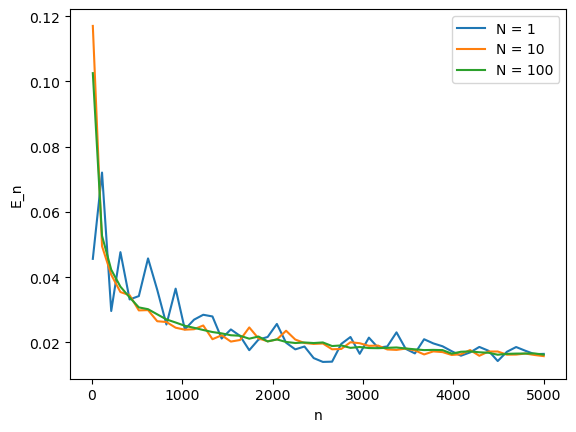

In [103]:
# Estimate MSE
ns = np.linspace(10, 5000)
Ns = np.array([1,10,100])
for N in Ns:
    E = []
    for n in ns:
        sigmahats = RM(Jhat, N=N, n=round(n))
        E.append(np.mean((sigmahats - sigma)**2))
    plt.plot(ns, E, label='N = ' + str(N))
plt.legend()
plt.xlabel('n')
plt.ylabel('E_n')

In [ ]:
# Asian put option
def Jhat_asian(sigma, N, m=50):
    S_avg = np.zeros(N)
    for j in range(N):
        W = np.zeros(m+1)
        for i in range(1,m+1):
            delta = norm.rvs(loc=0, scale=T/m)
            W[i] = W[i-1] + delta
        S = S0 * np.exp((r - sigma**2 / 2) * T + sigma * W)
        S_avg[j] = np.mean(S[1:])
    f = np.exp(-r*T) * (K - S_avg)
    f[f < 0] = 0
    return np.mean(f) - I_market

ns = np.linspace(10, 500)
sigmas = []
for n in ns:
    sigmahat = RM(Jhat_asian, N=10, n=round(n), size=1)[0]
    sigmas.append(sigmahat)

Text(0, 0.5, 'sigma')

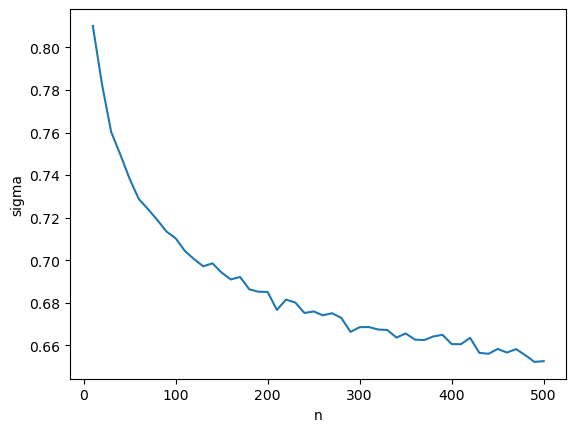

In [122]:
plt.plot(ns, sigmas)
plt.xlabel('n')
plt.ylabel('sigma')